In [30]:
# Imports and settings

import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import pandas as pd
from PIL import Image
import numpy as np
from r_pca import R_pca
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
# Load metadata CSV

df = pd.read_csv("balanced_metadata.csv")

# Filter for images that contain an animal
df = df[df["has_animal"] == 1].reset_index(drop=True)

# Fix image paths
df["image_path"] = "public/" + df["file_name"]

In [32]:
# Load and flatten images
TARGET_SIZE = (64, 64)

def load_and_flatten(path):
    img = Image.open(path).convert("L").resize(TARGET_SIZE)
    return np.array(img).flatten()

# Create image matrix X
X = np.array([load_and_flatten(path) for path in df["image_path"]])
print("Image matrix shape:", X.shape)  

Image matrix shape: (19794, 4096)


In [33]:
# Apply RPCA to separate low rank and sparse parts
rpca = R_pca(X)
L, S = rpca.fit(max_iter=1000, iter_print=100)

print("Low-rank shape:", L.shape)
print("Sparse shape:", S.shape)

iteration: 1, error: 9.861729297443958
iteration: 2, error: 0.075728740829895
Low-rank shape: (19794, 4096)
Sparse shape: (19794, 4096)


In [34]:
# Apply PCA to sparse component
pca = PCA(n_components=50)
S_pca = pca.fit_transform(S)
print("After PCA:", S_pca.shape)

After PCA: (19794, 50)


In [52]:
# Agglomerative Clustering

from sklearn.cluster import AgglomerativeClustering

num_clusters = df["species"].nunique() # Number of species

agglo = AgglomerativeClustering(n_clusters=num_clusters)
clusters = agglo.fit_predict(S_pca)

df["cluster"] = clusters # save labels


In [36]:
# Encode true species labels

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["species_encoded"] = le.fit_transform(df["species"])


Adjusted Rand Index (ARI): 0.0043


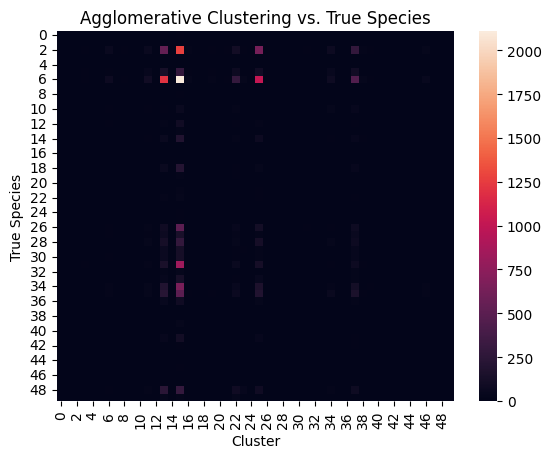

In [37]:
# Evaluate clustering performance

ari = adjusted_rand_score(df["species_encoded"], df["cluster"])
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

#Confusion matrix
cm = confusion_matrix(df["species_encoded"], df["cluster"])
sns.heatmap(cm, fmt="d")
plt.title("Agglomerative Clustering vs. True Species")
plt.xlabel("Cluster")
plt.ylabel("True Species")
plt.show()


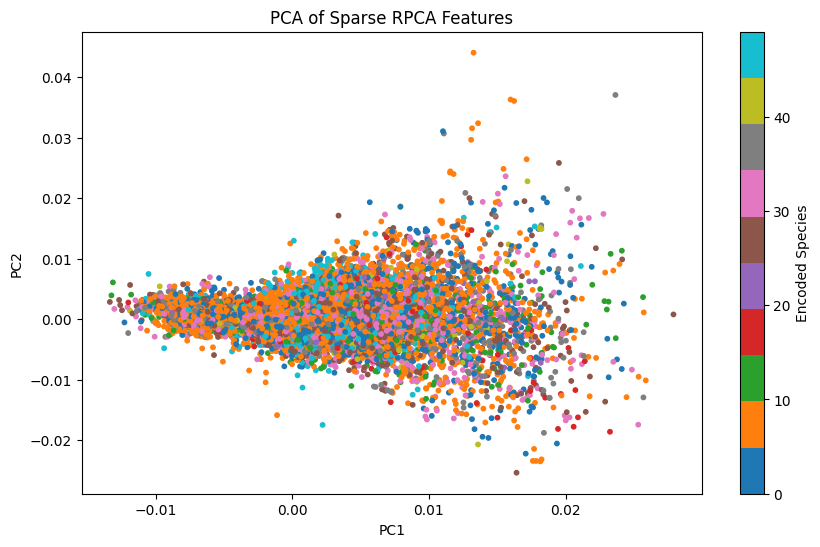

In [38]:
# PCA by species map
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(S_pca[:, 0], S_pca[:, 1], c=df["species_encoded"], cmap='tab10', s=10)
plt.title("PCA of Sparse RPCA Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label='Encoded Species')
plt.show()

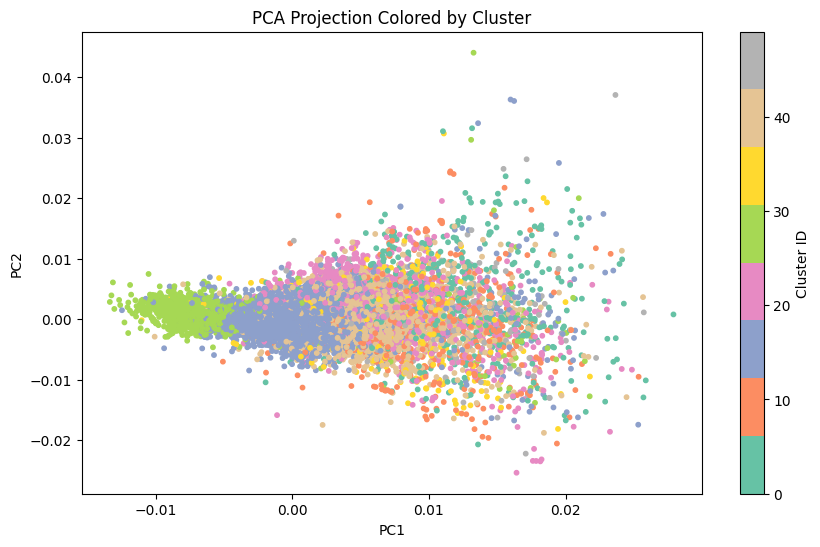

In [39]:
# PCA by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(S_pca[:, 0], S_pca[:, 1], c=df["cluster"], cmap='Set2', s=10)
plt.title("PCA Projection Colored by Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label='Cluster ID')
plt.show()


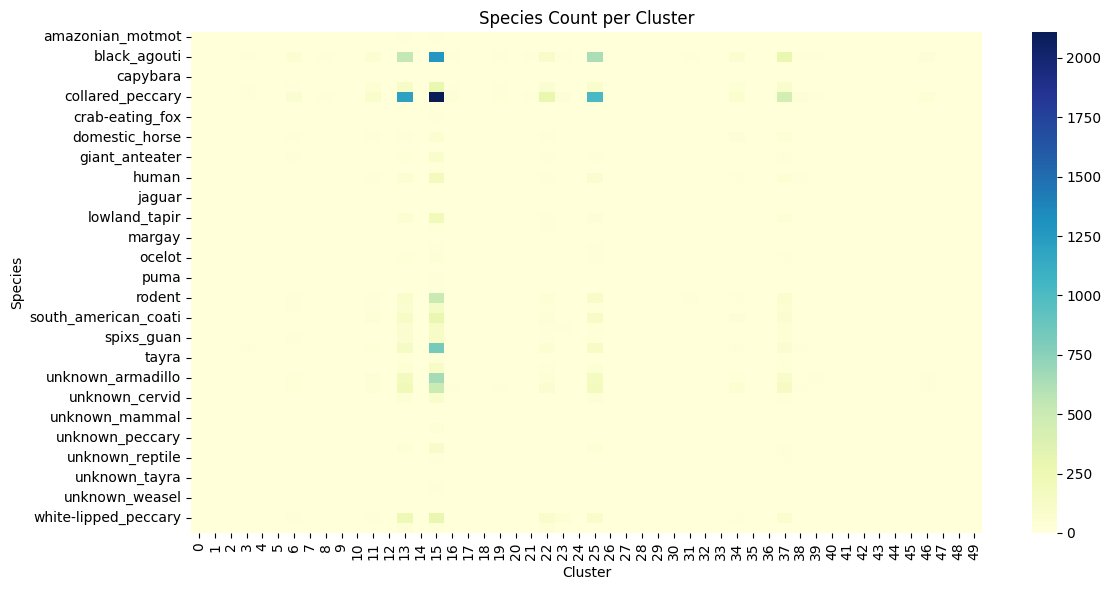

In [40]:
# Heatmap with species amount of clusters

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

heatmap_data = pd.crosstab(df["species"], df["cluster"])
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, fmt="d", cmap="YlGnBu")
plt.title("Species Count per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Species")
plt.tight_layout()
plt.show()


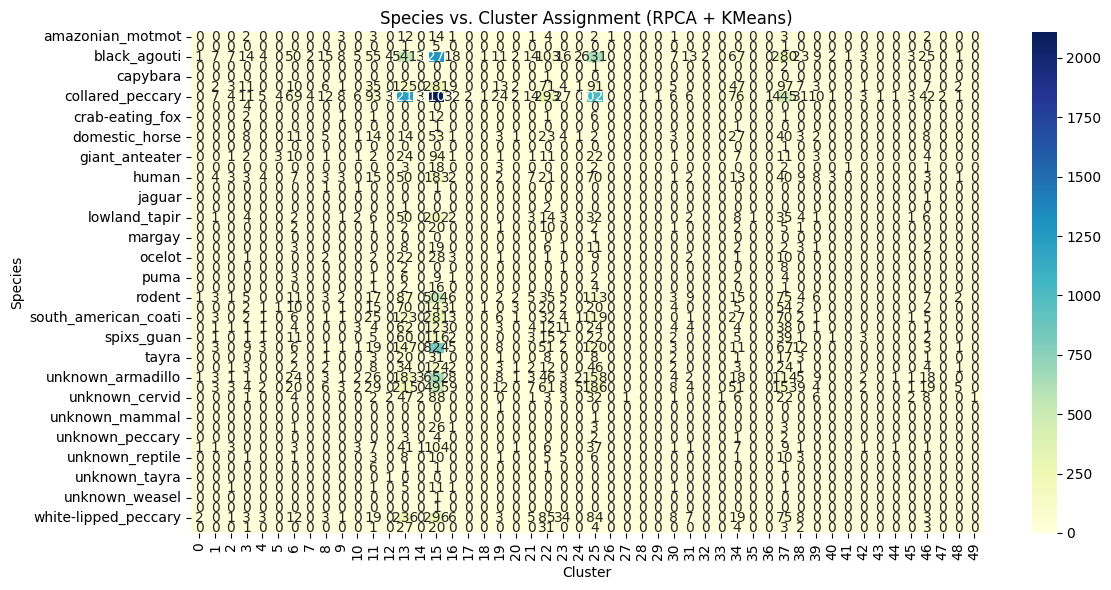

In [41]:
# Heatmap with numerical values
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = pd.crosstab(df["species"], df["cluster"])
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Species vs. Cluster Assignment (RPCA + KMeans)")
plt.xlabel("Cluster")
plt.ylabel("Species")
plt.tight_layout()
plt.show()


In [44]:
# NMI, Homogeneity, Completeness, and V-measure calculations
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import normalized_mutual_info_score
nmi = normalized_mutual_info_score(df["species_encoded"], df["cluster"])
print("NMI:", nmi)

print("Homogeneity:", homogeneity_score(df["species_encoded"], df["cluster"]))
print("Completeness:", completeness_score(df["species_encoded"], df["cluster"]))
print("V-measure:", v_measure_score(df["species_encoded"], df["cluster"]))


NMI: 0.03397487622620596
Homogeneity: 0.029770505013724698
Completeness: 0.0395620718758715
V-measure: 0.03397487622620596


In [15]:
# Imports
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [16]:
# Dataset reading

df = pd.read_csv("N16_balenced_labeled.csv")

if "image_path" not in df.columns:
    df["image_path"] = "public/" + df["file_name"]  
print(df.columns)
df.head()


Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'datetime', 'file_name', 'seq_id',
       'frame_num', 'seq_num_frames', 'location', 'category_id', 'has_animal',
       'species', 'image_path'],
      dtype='object')


,Unnamed: 0.1,Unnamed: 0,id,datetime,file_name,seq_id,frame_num,seq_num_frames,location,category_id,has_animal,species,image_path
0,0,8159,N16_02100241.JPG,2020-02-10 14:08:57+00:00,N16/02100241.JPG,398b1409-7160-11ec-84ec-5cf3706028c2,3,9,N16,0,1,empty,public/N16/02100241.JPG
1,1,57020,N16_04120451.JPG,2020-04-12 16:58:29+00:00,N16/04120451.JPG,398b3b29-7160-11ec-8b83-5cf3706028c2,0,3,N16,2,1,black_agouti,public/N16/04120451.JPG
2,2,14053,N16_04290548.JPG,2020-04-29 16:21:49+00:00,N16/04290548.JPG,398b6224-7160-11ec-a263-5cf3706028c2,1,3,N16,0,1,empty,public/N16/04290548.JPG
3,3,75734,N16_07160738.JPG,2020-07-16 10:59:09+00:00,N16/07160738.JPG,398b893a-7160-11ec-931b-5cf3706028c2,2,3,N16,6,1,unknown_bird,public/N16/07160738.JPG
4,4,2589,N16_05290632.JPG,2020-05-29 10:49:26+00:00,N16/05290632.JPG,398b623b-7160-11ec-9e9e-5cf3706028c2,1,3,N16,0,0,empty,public/N16/05290632.JPG


In [17]:
#Data preprocessing and training initialization

counts = df["species"].value_counts()
valid_species = counts[counts > 1].index
df = df[df["species"].isin(valid_species)].reset_index(drop=True)

df["label_encoded"] = LabelEncoder().fit_transform(df["species"])

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label_encoded"], random_state=42)


In [18]:
# Dataset function defining

class AnimalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = read_image(self.df.loc[idx, "image_path"]).float() / 255.0
        if self.transform:
            image = self.transform(image)
        label = self.df.loc[idx, "label_encoded"]
        return image, label


In [19]:
# Setting training and testing dataset and loader

weights = ViT_B_16_Weights.DEFAULT
transform = weights.transforms()

train_dataset = AnimalDataset(train_df, transform=transform)
test_dataset = AnimalDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [20]:
#Defining torchvision model

from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

model.heads.head = nn.Linear(model.heads.head.in_features, df["label_encoded"].nunique())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [21]:
# Importing and running 10 epochs of the model

import torch.optim as optim
import torch.nn as nn


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


/Users/kevindougherty/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Loss: 12.1822, Accuracy: 0.4810
Epoch 2, Loss: 10.4856, Accuracy: 0.5714
Epoch 3, Loss: 9.9275, Accuracy: 0.5714
Epoch 4, Loss: 9.5473, Accuracy: 0.5714
Epoch 5, Loss: 9.2025, Accuracy: 0.5714
Epoch 6, Loss: 9.0427, Accuracy: 0.5762
Epoch 7, Loss: 8.2831, Accuracy: 0.6095
Epoch 8, Loss: 7.6904, Accuracy: 0.6095
Epoch 9, Loss: 6.6031, Accuracy: 0.6952
Epoch 10, Loss: 5.1607, Accuracy: 0.7762


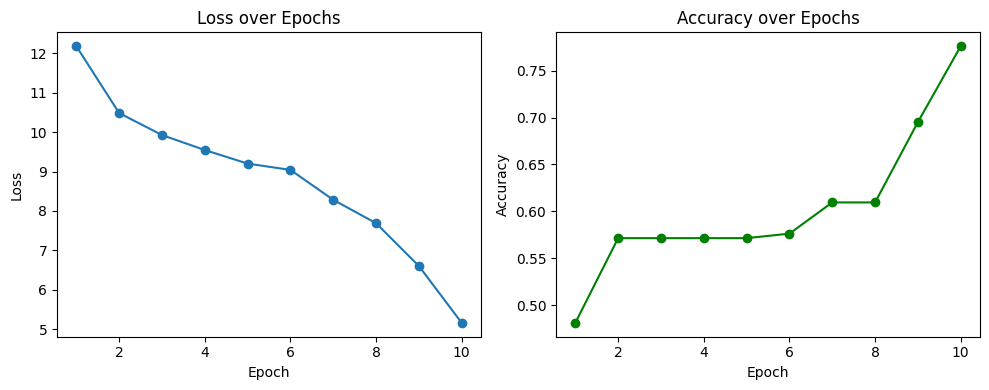

In [22]:
# Creating loss and accuracy over epochs graphs

import matplotlib.pyplot as plt

epochs = list(range(1, 11))
losses = [12.1822, 10.4856, 9.9275, 9.5473, 9.2025, 9.0427, 8.2831, 7.6904, 6.6031, 5.1607]
accs = [0.4810, 0.5714, 0.5714, 0.5714, 0.5714, 0.5762, 0.6095, 0.6095, 0.6952, 0.7762]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, accs, marker='o', color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [23]:
# test accuracy model evaluation

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


/Users/kevindougherty/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


✅ Test Accuracy: 0.5094


/Users/kevindougherty/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


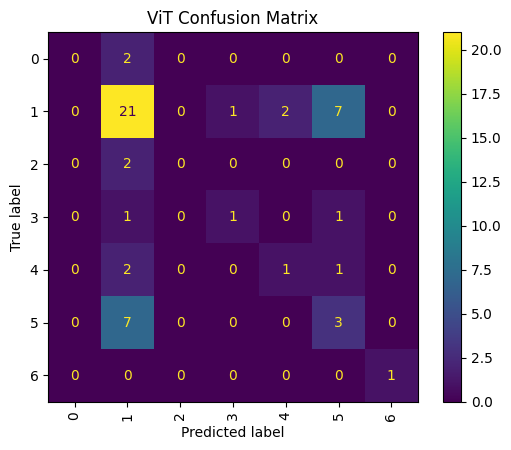

In [25]:
#ViT confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=90)
plt.title("ViT Confusion Matrix")
plt.show()


In [49]:
# model evaluation by top species

from sklearn.metrics import classification_report
import numpy as np

used_labels = np.unique(y_true)

target_names = le.inverse_transform(used_labels)

print(classification_report(y_true, y_pred, labels=used_labels, target_names=target_names, digits=3))


                  precision    recall  f1-score   support

amazonian_motmot      0.000     0.000     0.000         2
            ants      0.600     0.677     0.636        31
    black_agouti      0.000     0.000     0.000         2
        bush_dog      0.500     0.333     0.400         3
          cattle      0.333     0.250     0.286         4
collared_peccary      0.250     0.300     0.273        10
 crab-eating_fox      1.000     1.000     1.000         1

        accuracy                          0.509        53
       macro avg      0.383     0.366     0.371        53
    weighted avg      0.470     0.509     0.487        53



/Users/kevindougherty/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevindougherty/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevindougherty/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r